# summary data 
- record 04015 (09:00:00.120 - 09:11:07.428)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
dataset_dir = "dataset/AFDB record_04015/"
os.listdir(dataset_dir)

['annotation.txt', 'DATA.csv']

- Read Annotation file

In [4]:
file = open(dataset_dir + 'annotation.txt',"r") 
annotations = file.readlines()
file.close()

In [5]:
annotations

['      Time     Sample #  Type  Sub Chan  Num\tAux\n',
 '[09:00:00.120]       30     +    0    0    0\t(N\n',
 '[09:06:50.336]   102584     +    0    0    0\t(AFIB\n',
 '[09:07:58.416]   119604     +    0    0    0\t(N\n',
 '[09:08:07.092]   121773     +    0    0    0\t(AFIB\n',
 '[09:08:08.776]   122194     +    0    0    0\t(N\n',
 '[09:08:53.392]   133348     +    0    0    0\t(AFIB\n',
 '[09:11:07.428]   166857     +    0    0    0\t(N\n',
 '[10:13:04.980]  1096245     +    0    0    0\t(AFIB\n',
 '[10:13:12.216]  1098054     +    0    0    0\t(N\n',
 '[10:15:41.184]  1135296     +    0    0    0\t(AFIB\n',
 '[10:15:58.380]  1139595     +    0    0    0\t(N\n',
 '[10:34:49.744]  1422436     +    0    0    0\t(AFIB\n',
 '[10:34:54.192]  1423548     +    0    0    0\t(N\n',
 '[10:37:17.108]  1459277     +    0    0    0\t(AFIB\n',
 '[10:37:21.664]  1460416     +    0    0    0\t(N\n']

In [6]:
label_idx = []
for item in annotations[1:8] :
    item_split = item.split()
    label_idx.append([item_split[0].replace("[", "").replace("]", ""), item_split[-1].replace("(", "")])

In [7]:
label_idx

[['09:00:00.120', 'N'],
 ['09:06:50.336', 'AFIB'],
 ['09:07:58.416', 'N'],
 ['09:08:07.092', 'AFIB'],
 ['09:08:08.776', 'N'],
 ['09:08:53.392', 'AFIB'],
 ['09:11:07.428', 'N']]

- Read & formatting ECG data

In [9]:
df_04015 = pd.read_csv(dataset_dir + "DATA.csv", sep=",")

df_04015 = df_04015.drop(0) 
df_04015.columns = ['Time', 'ECG1', 'ECG2']

df_04015['ECG1'] = df_04015['ECG1'].str.replace(';;', '')
df_04015['ECG2'] = df_04015['ECG2'].str.replace(';;', '')
df_04015['ECG1'] = pd.to_numeric(df_04015['ECG1'])
df_04015['ECG2'] = pd.to_numeric(df_04015['ECG2'])

# peak reduction
df_04015[df_04015['ECG1'] > 2] = 2
df_04015[df_04015['ECG1'] < -2] = -2
df_04015[df_04015['ECG2'] > 2] = 2
df_04015[df_04015['ECG2'] < -2] = -2

df_04015["Time"] = df_04015['Time'].str.replace("[", "")
df_04015["Time"] = df_04015['Time'].str.replace("]", "")
df_04015["Time"] = df_04015['Time'].str.replace("'", "")

df_04015["Time"] = pd.to_datetime(df_04015["Time"], errors='coerce')

df_04015.set_index("Time", inplace=True)

In [10]:
df_04015.head()

,ECG1,ECG2
Time,,
2020-12-07 09:00:00.000,-0.275,-0.210
2020-12-07 09:00:00.004,-0.295,-0.200
2020-12-07 09:00:00.008,-0.310,-0.220
2020-12-07 09:00:00.012,-0.315,-0.225
2020-12-07 09:00:00.016,-0.300,-0.215


- plot signal 

In [41]:
def plot_signal(data, fs, label="ECG sample raw data"):
    ecg1 = data['ECG1'].values
    ecg2 = data['ECG2'].values

    times = np.arange(data.shape[0], dtype='float') / fs
    
    plt.figure(figsize=(20, 5))
    plt.title(label)
    plt.xlabel("Time (s)")
    plt.ylabel('mV')
    
    plt.plot(times, ecg1)
    plt.plot(times, ecg2)
    
    plt.ylim([-2.1, 2.1])
    plt.legend(["ecg 1", "ecg 2"])
    plt.grid(True)
    plt.show()

In [42]:
fs = 250 #hz

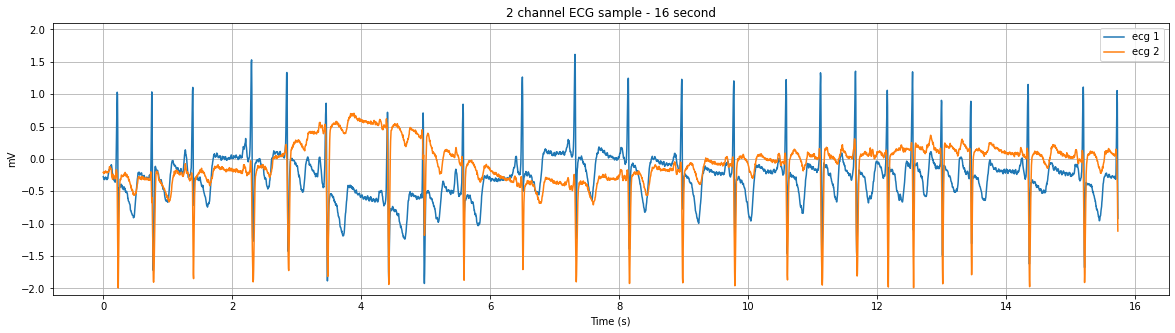

In [43]:
plot_signal(df_04015.between_time('09:00:00','09:00:16'), fs, "2 channel ECG sample - 16 second")

- Split Normal (N) and AFIB data

In [33]:
label_idx

[['09:00:00.120', 'N'],
 ['09:06:50.336', 'AFIB'],
 ['09:07:58.416', 'N'],
 ['09:08:07.092', 'AFIB'],
 ['09:08:08.776', 'N'],
 ['09:08:53.392', 'AFIB'],
 ['09:11:07.428', 'N']]

In [34]:
N_range = []
AFIB_range = []

for i in range(len(label_idx) - 1):
    tm_str = label_idx[i][0]
    next_tm_str = label_idx[i + 1][0]
    tm = pd.to_datetime(tm_str)
    next_tm = pd.to_datetime(next_tm_str)
    
    if label_idx[i][1] == 'N' :
        N_range.append([tm, next_tm])
    else :
        AFIB_range.append([tm, next_tm])

In [35]:
N = []
for nr in N_range :
    result = df_04015.between_time(nr[0].time(), nr[1].time())
    N.append(result)

In [36]:
AFIB = []
for ar in AFIB_range :
    result = df_04015.between_time(ar[0].time(), ar[1].time())
    AFIB.append(result)

- split each N & AFIB dataframe to 16s sequence and apply Baseline Removal 

In [37]:
from scipy import sparse
from scipy.sparse.linalg import spsolve
from datetime import timedelta

In [67]:
def plot_16s_sample(data, label="2 channel ECG plot - 16s sample", y_label = 'mV'):
    ecg1 = data[0]
    ecg2 = data[1]
    
    times = np.arange(ecg1.shape[0], dtype='float') / fs
    
    plt.figure(figsize=(20, 5))
    plt.plot(times, ecg1)
    plt.plot(times, ecg2)
    plt.title(label)
    plt.xlabel('Time (s)')
    plt.ylabel(y_label)
    plt.legend(["ecg1", "ecg2"])
    plt.grid(True)
    plt.show()

In [64]:
def baseline_als(y, lam=10000, p=0.05, n_iter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    w = np.ones(L)
    for i in range(n_iter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

In [65]:
def perdelta(start, end, delta):
    curr = start
    while curr < end:
        yield curr
        curr += delta

In [66]:
time_interval_N = []
for N_item in N:
    intr = [time_result for time_result in perdelta(N_item.index[0], N_item.index[-1], timedelta(seconds=16))]
    time_interval_N.append(intr)

In [48]:
time_interval_AFIB = []
for AFIB_item in AFIB:
    intr = [time_result for time_result in perdelta(AFIB_item.index[0], AFIB_item.index[-1], timedelta(seconds=16))]
    time_interval_AFIB.append(intr)

In [54]:
ECG_ALS = []
ECG_ALS_label = []

for time_interval in time_interval_N :
    for time_intv in list(zip(time_interval, time_interval[1:])):
        X = df_04015.between_time(time_intv[0].time(), time_intv[1].time())
        ecg1 = X['ECG1'].values
        ecg2 = X['ECG2'].values
        
        ALS1 = ecg1 - baseline_als(ecg1)
        ALS2 = ecg2 - baseline_als(ecg2)
        
        ECG_ALS.append(np.array([ALS1, ALS2]))
        ECG_ALS_label.append('N')
        
for time_interval in time_interval_AFIB :
    for time_intv in list(zip(time_interval, time_interval[1:])):
        X = df_04015.between_time(time_intv[0].time(), time_intv[1].time())
        ecg1 = X['ECG1'].values
        ecg2 = X['ECG2'].values
        
        ALS1 = ecg1 - baseline_als(ecg1)
        ALS2 = ecg2 - baseline_als(ecg2)
        
        ECG_ALS.append(np.array([ALS1, ALS2]))
        ECG_ALS_label.append('AF')

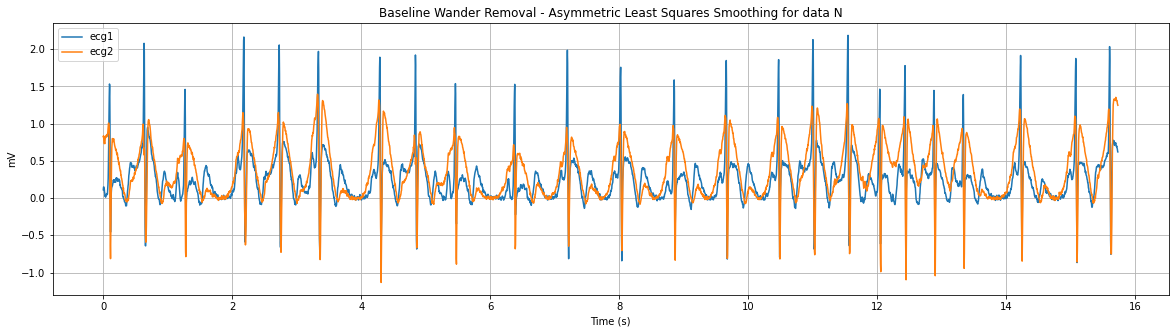

In [68]:
idx = 0
plot_16s_sample(ECG_ALS[idx], label="Baseline Wander Removal - Asymmetric Least Squares Smoothing for data %s" % ECG_ALS_label[idx])

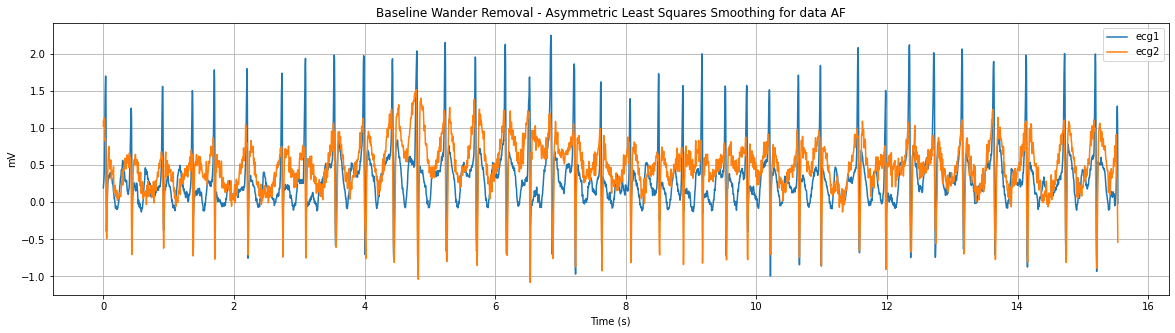

In [69]:
idx = -1
plot_16s_sample(ECG_ALS[idx], label="Baseline Wander Removal - Asymmetric Least Squares Smoothing for data %s" % ECG_ALS_label[idx])

- Signal normalization from -1 to 1

In [87]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler

In [88]:
#scaler = scaler = StandardScaler(with_mean=False, with_std=False) 
#scaler = MinMaxScaler(feature_range=(-1, 1)) # scale to -1 to 1
scaler = MaxAbsScaler()

ECG_ALS_Norm = []

for als in ECG_ALS :
    als1 = np.expand_dims(als[0], 1)
    als2 = np.expand_dims(als[1], 1)
    
    scaler.fit(als1)
    
    als_norm1 = scaler.transform(als1)
    als_norm2 = scaler.transform(als2)
    
    ECG_ALS_Norm.append([als_norm1, als_norm2])

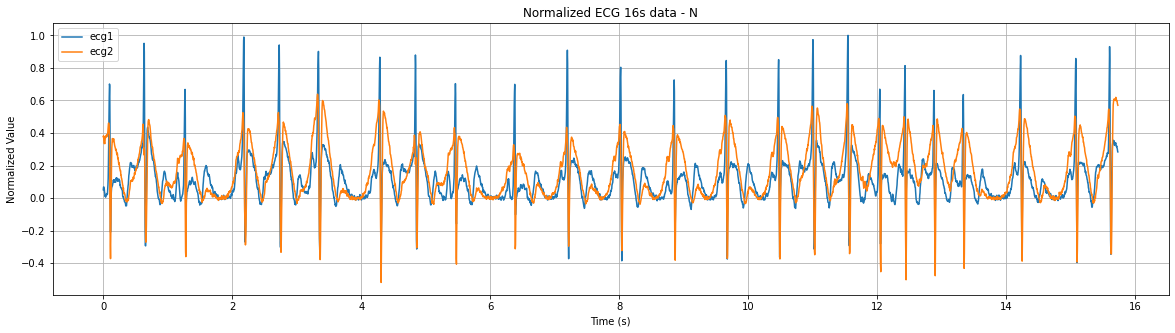

In [89]:
idx = 0
plot_16s_sample(ECG_ALS_Norm[idx], "Normalized ECG 16s data - %s" % ECG_ALS_label[idx], y_label = 'Normalized Value')

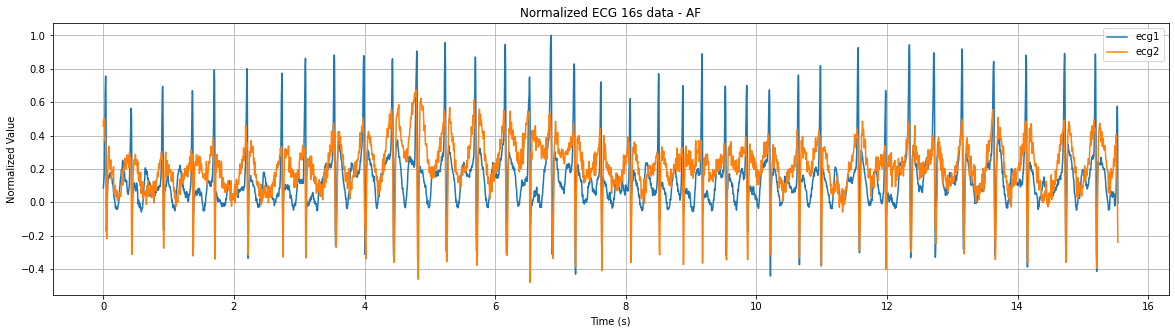

In [90]:
idx = -1
plot_16s_sample(ECG_ALS_Norm[idx], "Normalized ECG 16s data - %s" % ECG_ALS_label[idx], y_label = 'Normalized Value')

- QRS Detection

In [91]:
from ecgdetectors import Detectors

detectors = Detectors(fs)

In [92]:
def plot_r_peaks(r_peaks, data, fs, label = "Detected R peaks"):
    times = np.arange(data.shape[0], dtype='float') / fs

    ymin = np.min(data)
    ymax = np.max(data)
    alpha = 0.2 * (ymax - ymin)
    ymax += alpha
    ymin -= alpha

    plt.figure(figsize=(20, 5))
    plt.plot(times, data)
    
    plt.vlines([r / fs for r in r_peaks], ymin, ymax,
               color="r",
               linewidth=2)

    plt.title(label)
    plt.xlabel('Time (s)')
    plt.ylabel('mV')
    plt.grid(True)
    plt.show()

- Test R peak detector - Christov

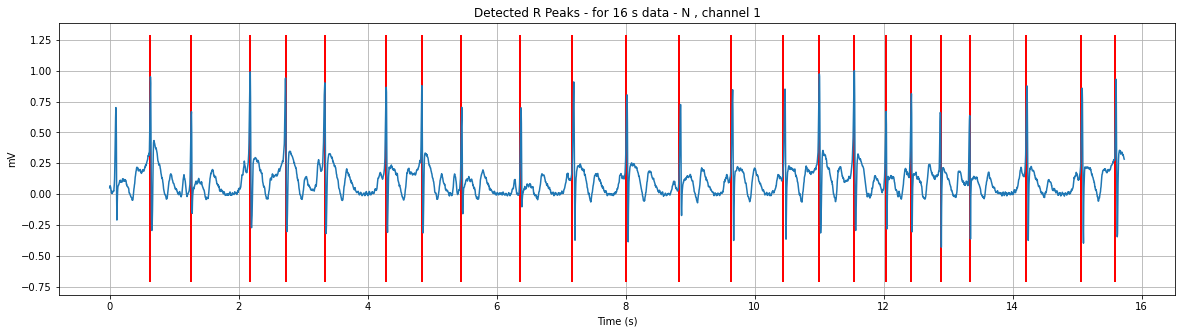

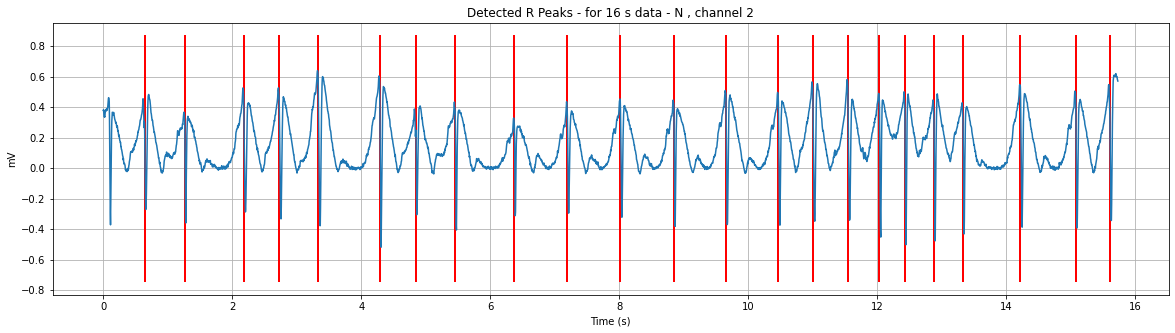

In [94]:
idx = 0

data = np.array(ECG_ALS_Norm[idx])

for ch in range(0,2):
    r_peaks = detectors.christov_detector(data[ch])
    plot_r_peaks(r_peaks, data[ch], fs, label="Detected R Peaks - for 16 s data - %s , channel %d" % (ECG_ALS_label[idx], ch + 1))

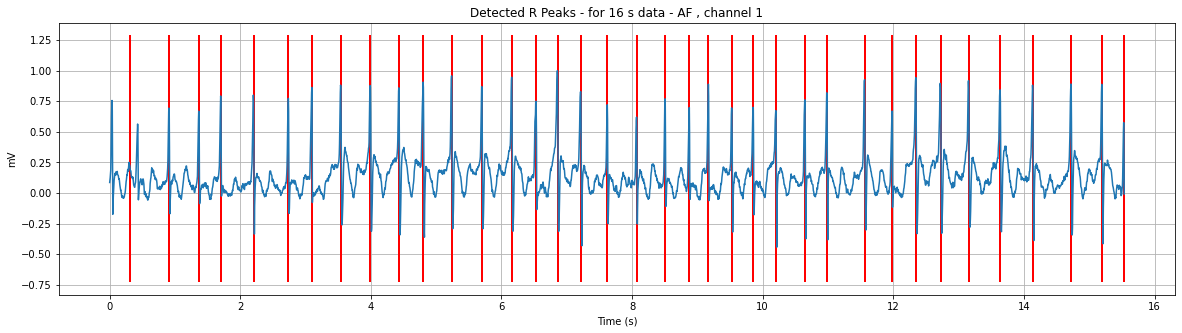

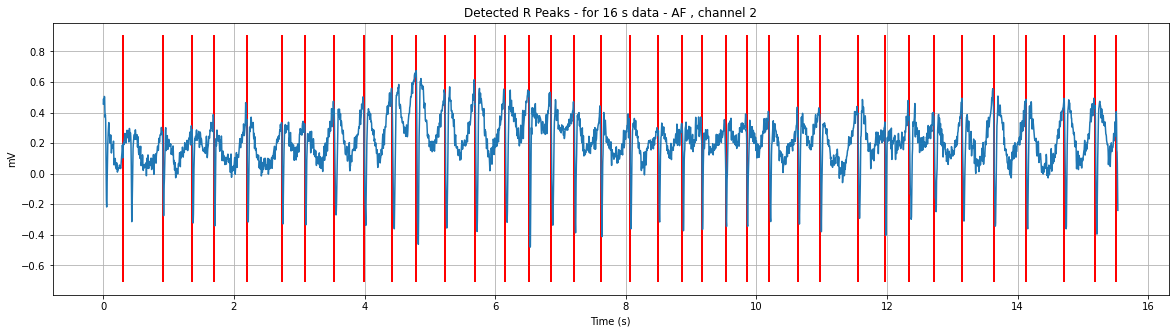

In [95]:
idx = -1

data = np.array(ECG_ALS_Norm[idx])

for ch in [0, 1]:
    r_peaks = detectors.christov_detector(data[ch])
    plot_r_peaks(r_peaks, data[ch], fs, label="Detected R Peaks - for 16 s data - %s , channel %d" % (ECG_ALS_label[idx], ch + 1))

- Split each 16s to 1.2 x R-R sequence
- Padding the sequence with zero for length 300 point

In [100]:
ECG_split = []
ECG_split_label = []
for i in range(len(ECG_ALS_Norm)) :
    data = np.array(ECG_ALS_Norm[i])
    r_peaks = detectors.christov_detector(data[0])
    RRs = np.diff(r_peaks)
    RRs_med = np.median(RRs)
    for rp in r_peaks :
        split1 = data[0][:,0][rp : rp + int(RRs_med * 1.2)] 
        split2 = data[1][:,0][rp : rp + int(RRs_med * 1.2)] 
        pad1 = np.zeros(300)
        pad2 = np.copy(pad1)
        pad1[0:len(split1)] = split1
        pad2[0:len(split2)] = split2
        ECG_split.append([pad1, pad2])
        ECG_split_label.append(ECG_ALS_label[i])

In [107]:
def plot_1_sample(data, label, fs):
    ecg1 = data[0]
    ecg2 = data[1]
    times = np.arange(ecg1.shape[0]) / fs * 1000 

    label = 'Normal' if label == 'N' else 'Atrial Fibrillation'
    plt.plot(times, ecg1)
    plt.plot(times, ecg2)
    plt.title("Plot 1 Sample (%dHz) : %s Beat" % (fs, label))
    plt.xlabel("Time (ms)")
    plt.ylabel("mV")
    plt.legend(["ecg 1", "ecg 2"])
    plt.grid(True)
    plt.show()

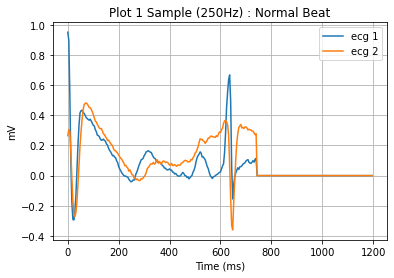

In [108]:
idx = 0
plot_1_sample(ECG_split[idx], ECG_split_label[idx], fs)

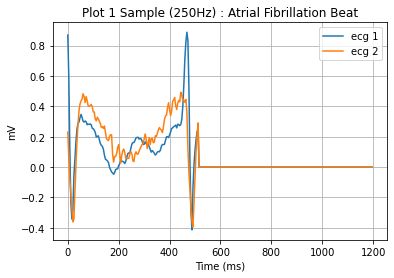

In [111]:
idx = -3
plot_1_sample(ECG_split[idx], ECG_split_label[idx], fs)

In [112]:
data = []
for i in range(len(ECG_split)):
    x = list(ECG_split[i][0])
    x.extend(list(ECG_split[i][1]))
    x.append(ECG_split_label[i])
    data.append(x)

In [113]:
ECG = pd.DataFrame(data)

In [114]:
ECG.tail()

,0,1,2,3,4,5,6,7,8,9,...,591,592,593,594,595,596,597,598,599,600
1138,0.843247,0.742867,0.379657,-0.061929,-0.295182,-0.315713,-0.232480,-0.154413,-0.043696,0.086369,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AF
1139,0.844177,0.526709,0.022134,-0.302797,-0.388114,-0.122686,-0.000020,0.102178,0.150588,0.203033,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AF
1140,0.869928,0.588169,0.117015,-0.230136,-0.342182,-0.281402,-0.058909,0.058560,0.166628,0.249768,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AF
1141,0.833458,0.522778,0.033901,-0.295323,-0.413816,-0.130424,0.016888,0.112623,0.179035,0.233935,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AF
1142,0.575983,0.459710,-0.007805,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AF


In [115]:
ECG.to_csv("dataset/AFDB_04015_sequence_300_pt_2_ch.csv", index=False, header=False)